In [1]:
from dataset_creation import TextDataset
from torch.utils.data import DataLoader
import numpy as np
import torch

# Instantiate the dataset
text_dataset = TextDataset(directory='data/SPGC-tokens-2018-07-18/', sequence_length=10)
print(f"Dataset created with {len(text_dataset)} sequences.")

# Define chars using keys of char_to_idx
chars = list(text_dataset.char_to_idx.keys())

n_characters = text_dataset.n_characters  # Number of unique characters
print(f"Number of unique characters: {n_characters}")
print(f"Characters: {chars}")

Dataset created with 18427254087 sequences.
Number of unique characters: 70
Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ',', '.', ';', "'", '"', '?', '!', ' ']


In [2]:
from hebbian_model import HebbianLinear, SimpleRNN, clip_weights
# Import the functions for saving model data
from vis import register_hooks, save_model_data

input_size = n_characters
output_size = n_characters
n_hidden = 128
rnn = SimpleRNN(input_size, n_hidden, output_size, 3)

# Register hooks to capture activations
activations = register_hooks(rnn)

# Initialize a counter for training instances
training_instance = 0

# Define the loss function (criterion)
criterion = torch.nn.NLLLoss()

In [3]:
def randomTrainingExample():
    """Generate a random training example from the dataset"""
    sequence, line_tensor = text_dataset[np.random.randint(len(text_dataset))]
    return sequence, line_tensor

randomTrainingExample()

(' last it i', tensor([69, 11,  0, 18, 19, 69,  8, 19, 69,  8]))

In [4]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
imprint_rate = 0.00005
last_n_rewards = [0]
last_n_reward_avg = 0
n_rewards = 100
stochasticity = 0.0001
save_frequency = 10  # Save data every 10 characters

def train(line_tensor):
    global training_instance
    hidden = rnn.initHidden()
    rnn.zero_grad()
    losses = []
    output = None
    for i in range(line_tensor.size()[0] - 1):
        hot_input_char_tensor = torch.nn.functional.one_hot(line_tensor[i], num_classes=n_characters).type(torch.float).unsqueeze(0)
        output, hidden = rnn(hot_input_char_tensor, hidden)

        # print("output shape:", output.shape)
        # print("line_tensor shape:", line_tensor.shape)
        # print(output)
        # print(line_tensor[-1].unsqueeze(0))
        loss = criterion(output, line_tensor[-1].unsqueeze(0))
        # print(loss)

        # Convert loss to a reward signal
        reward = 1 / (1 + loss.item())  # Example conversion, assuming loss is non-negative
        # print(reward)

        # update last_n_rewards
        last_n_rewards.append(reward)
        if len(last_n_rewards) > n_rewards:
            last_n_rewards.pop(0)
        last_n_reward_avg = sum(last_n_rewards) / len(last_n_rewards)
        reward_update = reward - last_n_reward_avg
        # print(reward_update)
        clip_weights(rnn, max_norm=0.5)  # Choose an appropriate max_norm value

        # Apply Hebbian updates
        rnn.apply_imprints(reward_update, learning_rate, imprint_rate)

        # Apply stochasticity
        for p in rnn.parameters():
            noise = stochasticity * torch.randn_like(p.data)
            # print(noise)
            p.data += noise

        losses.append(loss.item())
        if (training_instance % save_frequency == 0) and (i % 5 == 0):
            # Save model data at specified frequency
            save_model_data(rnn, activations, training_instance, i)
        training_instance += 1
    
    loss_avg = sum(losses) / len(losses)
    return output, loss_avg


In [5]:
import wandb
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="hebby",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "crazy hebbian thing",
    "dataset": "wikidump",
    "epochs": 1,
    "stochasticity": stochasticity,
    "imprint_rate": imprint_rate,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jaden-lorenc (jadens_team). Use `wandb login --relogin` to force relogin


In [6]:
import time
import math

n_iters = 10000
print_every = 50
plot_every = 1

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    sequence, line_tensor = randomTrainingExample()
    output, loss = train(line_tensor)
    current_loss += loss
    wandb.log({"loss": loss})
    # Check if loss is NaN
    if math.isnan(loss):
        print("Loss is NaN, breaking...")
        parameters = list(rnn.parameters())
        for p in parameters:
            print(p.data)
        break
    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        # Use the output to generate a character prediction
        topv, topi = output.topk(1, dim=1)  # Change dim to 1
        predicted_char = text_dataset.idx_to_char[topi[0, 0].item()]
        target_char = sequence[-1]
        correct = '✓' if predicted_char == target_char else '✗ (%s)' % target_char
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, sequence, predicted_char, correct))
        wandb.log({"correct": correct, "predicted_char": predicted_char, "target_char": target_char, "sequence": sequence})

        # also print some weights:
        # print("i2h weights:", rnn.i2h.weight)
        # print("i2o weights:", rnn.i2o.weight)

    # Add current loss avg to list of losses source /home/deck/miniconda3/bin/activate /home/deck/Documents/memory_encoding/hebby
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

50 0% (0m 1s) 4.1535 of grobben / h ✗ (n)
100 1% (0m 2s) 4.3480  and singi / h ✗ (i)
150 1% (0m 4s) 4.2675 nhouse pee / h ✗ (e)
200 2% (0m 5s) 4.3089 iene due v / h ✗ (v)
250 2% (0m 7s) 4.2177 n a coop a / h ✗ (a)
300 3% (0m 8s) 4.3192 ederal gov / h ✗ (v)
350 3% (0m 9s) 4.2171 or cocarda / h ✗ (a)
400 4% (0m 11s) 4.2652 ven assist / h ✗ (t)
450 4% (0m 12s) 4.2249 numerous o / h ✗ (o)
500 5% (0m 14s) 4.2655 untry to t / h ✗ (t)
550 5% (0m 15s) 4.3389  you to sp / h ✗ (p)
600 6% (0m 17s) 4.3300  remote or / h ✗ (r)
650 6% (0m 18s) 4.3089 ita sonja  / h ✗ ( )
700 7% (0m 19s) 4.3583 ate of thi / h ✗ (i)
750 7% (0m 21s) 4.3105 ongst the  / h ✗ ( )
800 8% (0m 22s) 4.2549 d woman ol / h ✗ (l)
850 8% (0m 24s) 4.2819 all warm s / h ✗ (s)
900 9% (0m 25s) 4.2988 ée par la  / h ✗ ( )
950 9% (0m 27s) 4.3324 n and hatr / h ✗ (r)
1000 10% (0m 28s) 4.2317 ife withou / h ✗ (u)
1050 10% (0m 30s) 4.2237 tage or no / h ✗ (o)
1100 11% (0m 31s) 4.2450 d before t / h ✗ (t)
1150 11% (0m 32s) 4.2955  front of

KeyboardInterrupt: 

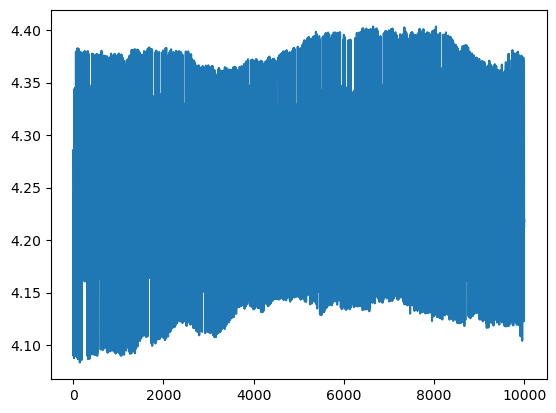

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)